## Transfert learning 

Transfert learning is a method consisting in re-using a trained model. The trained model will be retrained on the target dataset. 

For instance, let's say you want to train  classification tasks about cars. You could take a neural network already trained on generic image classification and train it again on your dataset.

The basic idea is that it will be quicker to train a "competent" network in a similar task than from starting from an empty "brain". 

In this notebook we will use this method and try to see the various methods

**In order to do this notebook, you may want to do the Keras Api Fonctionnelle on Nowledgeable**

Keras has various pretrained models available at https://keras.io/api/applications/

We will use theses pretrained model as it they were a simple layer. 


We will start with mobilenet



From the keras.applications module, load the the mobile net network into a variable named base_model

Use include_top = False so that the Dense layers are removed

In [1]:
from tensorflow.keras import Model, Input
from tensorflow.keras.applications import MobileNetV2

In [2]:
from tensorflow.keras.datasets.cifar10 import load_data

data = load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [3]:
train, test = data

In [4]:
import matplotlib.pyplot as plt

X_train, y_train = train
X_test, y_test = test

In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

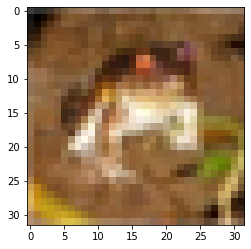

In [7]:
plt.imshow(X_train[0])

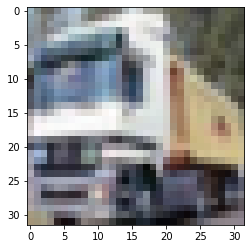

In [8]:
plt.imshow(X_train[1])

In [9]:
images_count, image_height, image_width, color_count = X_train.shape

In [10]:
X_train = X_train / 255
X_test = X_test / 255

In [11]:
import numpy as np
class_values = np.unique(data[0][1]) # or else len(set(y_train))
class_count = len(np.array(class_values))
class_count, class_values

(10, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=[image_height, image_width, color_count])

display the number of layer of this base model

In [ ]:
len(base_model.layers)

154

Display all the layer of the model. You should see only convolutional layers

In [ ]:
base_model.layers

Now we want to add our own dense layers on top of the model. 
We have two ways of doing that : either using the sequential api or the functional one 


Create a model using the base model and two Dense layer (400 and 200 neurones ) + the final layer to do classification 

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(class_count, activation='softmax')) # as many neurones as classes
# softmax normalizes the model's outputs so that it looks like a proba distribution with Sum(output_i) = 1

You can change the configuration of a layer and decide if it is trainable or not. 

If a layer is not trainable it means that the parameters will not be updated during the model training. 


Loop over the layers of the model and display if the layers are trainable or not

In [ ]:
for layer in model.layers:
  print(layer.trainable)

True
True
True
True
True


We will conduct the following tests : 

- train a transfer learning model where the base model layers are not trainable
- train a transfer learning model where the last layer of the base model layer is trainable
- increase progressively the number of layers which are trainable 






In [ ]:
import pandas as pd

## Not training base model layers 

With a for loop over the base model layers, make sure to make the layers untrainable. 




In [ ]:
def make_untrainable(layer):
  layer.trainable = False

pd.Series(base_model.layers).apply(lambda layer: make_untrainable(layer))

trainabilities = pd.Series(base_model.layers).map(lambda layer: layer.trainable)
len(trainabilities.loc[trainabilities == True])

0

Train the model on the cifar 10 data

In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# categorical_crossentropy : used when class values are already one-hot-encoded
# sparse_categorical_crossentropy : used when class values are not already one-hot-encoded

In [ ]:
model_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model_history

Epoch 1/10
1563/1563 [==============================] - 35s 20ms/step - loss: 2.1644 - accuracy: 0.2220 - val_loss: 2.0551 - val_accuracy: 0.2553
Epoch 2/10
1563/1563 [==============================] - 30s 19ms/step - loss: 2.0036 - accuracy: 0.2725 - val_loss: 1.9755 - val_accuracy: 0.2861
Epoch 3/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.9437 - accuracy: 0.2970 - val_loss: 1.9346 - val_accuracy: 0.2972
Epoch 4/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.9118 - accuracy: 0.3049 - val_loss: 1.9120 - val_accuracy: 0.3021
Epoch 5/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.8901 - accuracy: 0.3137 - val_loss: 1.8906 - val_accuracy: 0.3137
Epoch 6/10
1563/1563 [==============================] - 27s 18ms/step - loss: 1.8733 - accuracy: 0.3188 - val_loss: 1.8803 - val_accuracy: 0.3147
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.8588 - accuracy: 0.3241 - val_loss: 1.8723 -

## Last based layer trainning 

Do the same thing as before and but make the last layer of the base model trainable

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=[image_height, image_width, color_count])

In [ ]:
def make_untrainable(layer):
  layer.trainable = False

pd.Series(base_model.layers).apply(lambda layer: make_untrainable(layer))

0      None
1      None
2      None
3      None
4      None
       ... 
149    None
150    None
151    None
152    None
153    None
Length: 154, dtype: object

In [ ]:
base_model.layers[-1].trainable = True
trainabilities = pd.Series(base_model.layers).map(lambda layer: layer.trainable)
trainable_layer_index = trainabilities.loc[trainabilities == True].index
last_layer_index = len(base_model.layers) - 1
print(last_layer_index, trainable_layer_index)

153 Int64Index([153], dtype='int64')


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(class_count, activation='softmax')) # as many neurones as classes
# softmax normalizes the model's outputs so that it looks like a proba distribution with Sum(output_i) = 1

In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# categorical_crossentropy : used when class values are already one-hot-encoded
# sparse_categorical_crossentropy : used when class values are not already one-hot-encoded

In [ ]:
model_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model_history

Epoch 1/10
1563/1563 [==============================] - 37s 21ms/step - loss: 2.1604 - accuracy: 0.2233 - val_loss: 2.0551 - val_accuracy: 0.2469
Epoch 2/10
1563/1563 [==============================] - 31s 20ms/step - loss: 2.0043 - accuracy: 0.2758 - val_loss: 1.9737 - val_accuracy: 0.2834
Epoch 3/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.9470 - accuracy: 0.2940 - val_loss: 1.9371 - val_accuracy: 0.2975
Epoch 4/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.9149 - accuracy: 0.3038 - val_loss: 1.9165 - val_accuracy: 0.3042
Epoch 5/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.8926 - accuracy: 0.3133 - val_loss: 1.8942 - val_accuracy: 0.3120
Epoch 6/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.8756 - accuracy: 0.3179 - val_loss: 1.8824 - val_accuracy: 0.3181
Epoch 7/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.8618 - accuracy: 0.3238 - val_loss: 1.8718 -

## More layers trainable

Make all the layer trainable and train the model 

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=[image_height, image_width, color_count])

In [ ]:
def make_trainable(layer):
  layer.trainable = True

pd.Series(base_model.layers).apply(lambda layer: make_trainable(layer))

0      None
1      None
2      None
3      None
4      None
       ... 
149    None
150    None
151    None
152    None
153    None
Length: 154, dtype: object

In [ ]:
trainabilities = pd.Series(base_model.layers).map(lambda layer: layer.trainable)
trainable_layer_count = len(trainabilities.loc[trainabilities == True])
layer_count = len(base_model.layers)
print(layer_count, trainable_layer_count)

154 154


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(class_count, activation='softmax')) # as many neurones as classes
# softmax normalizes the model's outputs so that it looks like a proba distribution with Sum(output_i) = 1

In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# categorical_crossentropy : used when class values are already one-hot-encoded
# sparse_categorical_crossentropy : used when class values are not already one-hot-encoded

In [ ]:
model_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model_history

Epoch 1/10
1563/1563 [==============================] - 63s 37ms/step - loss: 1.5505 - accuracy: 0.4516 - val_loss: 2.2366 - val_accuracy: 0.2245
Epoch 2/10
1563/1563 [==============================] - 58s 37ms/step - loss: 1.0528 - accuracy: 0.6365 - val_loss: 1.6349 - val_accuracy: 0.6110
Epoch 3/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.8952 - accuracy: 0.6914 - val_loss: 1.0689 - val_accuracy: 0.6680
Epoch 4/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.7926 - accuracy: 0.7252 - val_loss: 0.9454 - val_accuracy: 0.6890
Epoch 5/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.7173 - accuracy: 0.7525 - val_loss: 1.0058 - val_accuracy: 0.6581
Epoch 6/10
1563/1563 [==============================] - 57s 37ms/step - loss: 0.6593 - accuracy: 0.7707 - val_loss: 0.7945 - val_accuracy: 0.7332
Epoch 7/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.6092 - accuracy: 0.7887 - val_loss: 0.8218 -

The model's performances seem way better

## Last method : 

Train only the last layers and then finetune 

In [12]:
base_model = MobileNetV2(include_top=False, input_shape=[image_height, image_width, color_count])

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [14]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(class_count, activation='softmax')) # as many neurones as classes
# softmax normalizes the model's outputs so that it looks like a proba distribution with Sum(output_i) = 1

In [15]:
import pandas as pd

In [16]:
def make_untrainable(layer):
  layer.trainable = False

pd.Series(base_model.layers).apply(lambda layer: make_untrainable(layer))

trainabilities = pd.Series(base_model.layers).map(lambda layer: layer.trainable)
len(trainabilities.loc[trainabilities == True])

0

In [17]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# categorical_crossentropy : used when class values are already one-hot-encoded
# sparse_categorical_crossentropy : used when class values are not already one-hot-encoded

In [18]:
model_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model_history

Epoch 1/10
1563/1563 [==============================] - 39s 18ms/step - loss: 2.1640 - accuracy: 0.2229 - val_loss: 2.0517 - val_accuracy: 0.2561
Epoch 2/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.0020 - accuracy: 0.2728 - val_loss: 1.9721 - val_accuracy: 0.2810
Epoch 3/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.9453 - accuracy: 0.2945 - val_loss: 1.9340 - val_accuracy: 0.2957
Epoch 4/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.9141 - accuracy: 0.3051 - val_loss: 1.9115 - val_accuracy: 0.3048
Epoch 5/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.8924 - accuracy: 0.3113 - val_loss: 1.8940 - val_accuracy: 0.3098
Epoch 6/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.8755 - accuracy: 0.3176 - val_loss: 1.8827 - val_accuracy: 0.3159
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.8620 - accuracy: 0.3226 - val_loss: 1.8689 -

In [19]:
def make_trainable(layer):
  layer.trainable = True

pd.Series(base_model.layers).apply(lambda layer: make_trainable(layer))

0      None
1      None
2      None
3      None
4      None
       ... 
149    None
150    None
151    None
152    None
153    None
Length: 154, dtype: object

In [20]:
trainabilities = pd.Series(base_model.layers).map(lambda layer: layer.trainable)
trainable_layer_count = len(trainabilities.loc[trainabilities == True])
layer_count = len(base_model.layers)
print(layer_count, trainable_layer_count)

154 154


In [21]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# categorical_crossentropy : used when class values are already one-hot-encoded
# sparse_categorical_crossentropy : used when class values are not already one-hot-encoded

In [22]:
model_history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
model_history

Epoch 1/10
1563/1563 [==============================] - 60s 35ms/step - loss: 1.6454 - accuracy: 0.4111 - val_loss: 2.4179 - val_accuracy: 0.1639
Epoch 2/10
1563/1563 [==============================] - 55s 35ms/step - loss: 1.1900 - accuracy: 0.5761 - val_loss: 1.7374 - val_accuracy: 0.4135
Epoch 3/10
1563/1563 [==============================] - 53s 34ms/step - loss: 1.0256 - accuracy: 0.6395 - val_loss: 1.4206 - val_accuracy: 0.5058
Epoch 4/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.9231 - accuracy: 0.6811 - val_loss: 1.4878 - val_accuracy: 0.4749
Epoch 5/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.8739 - accuracy: 0.6958 - val_loss: 0.9464 - val_accuracy: 0.6864
Epoch 6/10
1563/1563 [==============================] - 54s 34ms/step - loss: 0.7749 - accuracy: 0.7315 - val_loss: 0.9864 - val_accuracy: 0.6593
Epoch 7/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.7350 - accuracy: 0.7446 - val_loss: 0.7768 -

Fine tuning did improve the model's global loss and accuracy

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b859965-b858-4b8d-a841-009599aef86e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>